In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

Updated 1/27/17

In this notebook, I explore the sample fire dispatch data provided to HACK OR Emergency Response Project Team. NOTE: this notebook was updated with queries on the updated db with dispatch data from PF&R dating back to 01/01/10.
See this [link](https://github.com/hackoregon/emergency-response/wiki/Data-Dictionary#incident-table) for the codebook/schema descriptions for the PF&R dispatch data.

Research questions explored thus far in this notebook:
*  for incidents (within the incident table), what are the types of incidfoundclass_id labels? How many of each type are there?
*  for incidents, there is another type of categorical label, typenaturecode, which is much more specific. As in 1) above, what are the types of lables and now many of each are there?

In [4]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

In [5]:
# ucomment to check environment variables
#%env

In [6]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("erdatabase"), user=os.environ.get("eruser"), 
                            password = os.environ.get("erpassword"), 
                            host=os.environ.get("erhost"), port=os.environ.get("erport"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [7]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    
    if conn is None:
        return None
    
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)
        
    finally:
        conn.close()


In [8]:
QUERY1='''SELECT incident.incident_id, incsitfoundclass.incsitfoundclass_id, incsitfoundclass.description
FROM incident
  INNER JOIN incsitfound
    ON incident.incsitfoundprm_id = incsitfound.incsitfound_id
  LEFT JOIN incsitfoundsub
    ON incsitfound.incsitfoundsub_id = incsitfoundsub.incsitfoundsub_id
  LEFT JOIN incsitfoundclass
    ON incsitfoundsub.incsitfoundclass_id = incsitfoundclass.incsitfoundclass_id;
'''

In [9]:
df1 = pquery(QUERY1)

Opened database successfully
SQL QUERY = SELECT incident.incident_id, incsitfoundclass.incsitfoundclass_id, incsitfoundclass.description
FROM incident
  INNER JOIN incsitfound
    ON incident.incsitfoundprm_id = incsitfound.incsitfound_id
  LEFT JOIN incsitfoundsub
    ON incsitfound.incsitfoundsub_id = incsitfoundsub.incsitfoundsub_id
  LEFT JOIN incsitfoundclass
    ON incsitfoundsub.incsitfoundclass_id = incsitfoundclass.incsitfoundclass_id;



In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512281 entries, 0 to 512280
Data columns (total 3 columns):
incident_id            512281 non-null int64
incsitfoundclass_id    512281 non-null int64
description            512281 non-null object
dtypes: int64(2), object(1)
memory usage: 11.7+ MB


In [11]:
df1.head()

,incident_id,incsitfoundclass_id,description
0,754221,3,MEDICAL AID / RESCUE CALLS ...
1,754222,6,GOOD INTENT CALLS ...
2,754224,3,MEDICAL AID / RESCUE CALLS ...
3,754225,3,MEDICAL AID / RESCUE CALLS ...
4,754226,3,MEDICAL AID / RESCUE CALLS ...


In [12]:
df1.groupby('description')['description'].count().sort_values(ascending = 0)

description
MEDICAL AID / RESCUE CALLS                            368084
SERVICE CALL                                           50997
FALSE CALLS                                            39210
GOOD INTENT CALLS                                      24884
FIRE/EXPLOSION                                         16232
HAZARDOUS CONDITIONS                                   10564
OTHER SITUATION FOUND                                   1478
OVER PRESSURE RUPTURE, EXPLOSION, OVERHEAT               394
MUTUAL AID RESPONSE                                      253
NATURAL CONDITIONS                                       185
Name: description, dtype: int64

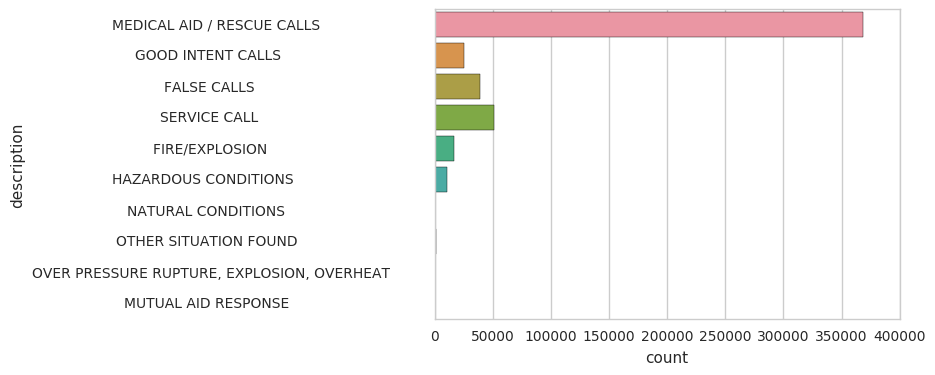

In [13]:
sns.set_style("whitegrid")
sns.countplot(y='description', data = df1)

In [14]:
# incident by desciption as % of total
tab = pd.crosstab(index='count', columns = df1['description']).apply(lambda r: r/r.sum(), axis=1)
tab

description,FALSE CALLS,FIRE/EXPLOSION,GOOD INTENT CALLS,HAZARDOUS CONDITIONS,MEDICAL AID / RESCUE CALLS,MUTUAL AID RESPONSE,NATURAL CONDITIONS,OTHER SITUATION FOUND,"OVER PRESSURE RUPTURE, EXPLOSION, OVERHEAT",SERVICE CALL
row_0,,,,,,,,,,
count,0.07654,0.031686,0.048575,0.020621,0.71852,0.000494,0.000361,0.002885,0.000769,0.099549


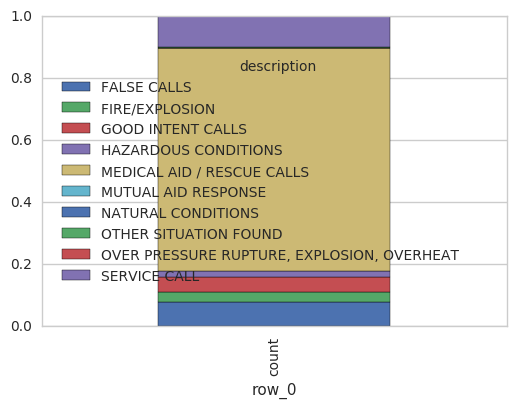

In [15]:
tab.plot.bar(stacked = True)

From our EDA thus far on the incident table, we can see some trends emerging for the overall dataset:
 - responder-categorized (by incidfound) incidents were overwhelmingly MEDICAL AID / RESCUE CALLS at 71.9% for all incidents since 01/01/10
 - the FALSE ALARM rate is 7.7% of all incidents
 - FIRE/EXPLOSION incidents only account for 3.2% of all incidents

In [16]:
QUERY2='''
SELECT incident.typenaturecode_id, typenaturecode.description, 
  count(incident.typenaturecode_id) as num
    FROM typenaturecode LEFT JOIN incident
    ON incident.typenaturecode_id = typenaturecode.typenaturecode_id
  GROUP BY incident.typenaturecode_id,typenaturecode.description
  ORDER BY num DESC;
'''

In [17]:
df2 = pquery(QUERY2)

Opened database successfully
SQL QUERY = 
SELECT incident.typenaturecode_id, typenaturecode.description, 
  count(incident.typenaturecode_id) as num
    FROM typenaturecode LEFT JOIN incident
    ON incident.typenaturecode_id = typenaturecode.typenaturecode_id
  GROUP BY incident.typenaturecode_id,typenaturecode.description
  ORDER BY num DESC;



In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 3 columns):
typenaturecode_id    302 non-null float64
description          477 non-null object
num                  477 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [19]:
df2[:50]

,typenaturecode_id,description,num
0,141.0,TRAUMA/1ST RESP ...,54556
1,30.0,BREATHING/1ST RESP ...,51444
2,39.0,CHEST PAIN/1ST RESP ...,46407
3,125.0,SICK/1ST RESP ...,39430
4,12.0,AUTOMATIC FIRE ALARM-COMM ...,30373
5,147.0,UNCONSCIOUS/1ST RESP ...,24283
6,1.0,ABDOMINAL/1ST RESP ...,23352
7,132.0,SEIZURE/1ST RESP ...,18072
8,134.0,TRAFFIC ACC/1ST RESP ...,17953
9,110.0,OVERDOSE/1ST RESP ...,16007


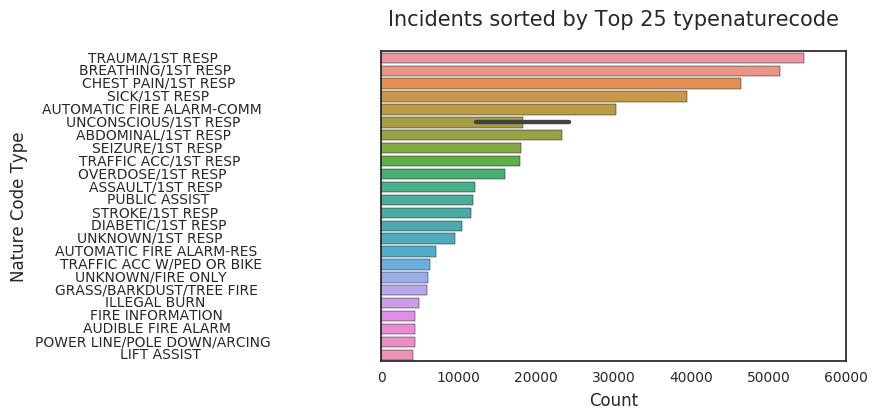

In [20]:
sns.set_style("white") 
brplot =  sns.barplot(x="num", y="description", data=df2[:25])
title = ('Incidents sorted by Top 25 typenaturecode')
# Add title with space below for x-axix ticks and label
brplot.set_title(title, fontsize=15, y=1.06)
brplot.set_ylabel('Nature Code Type', fontsize=12, rotation=90) # rota
brplot.set_xlabel('Count', fontsize=12)
brplot.tick_params(axis='both', labelsize=10)